In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
pip install split-folders


Note: you may need to restart the kernel to use updated packages.


In [2]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import splitfolders
import shutil
import seaborn as sns
import plotly.express as px
import keras 
from sklearn.metrics import confusion_matrix , classification_report 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

2024-06-24 05:56:00.832062: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-24 05:56:00.832157: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-24 05:56:00.959636: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
path = "/kaggle/input/sugarcane-leaf-disease-dataset"
print(os.listdir(path))

['Yellow', 'Mosaic', 'Healthy', 'RedRot', 'Rust']


In [4]:
splitfolders.ratio(path,seed=1337, output="Sugarcane-Splitted", ratio=(0.6, 0.2, 0.2))


Copying files: 2521 files [00:12, 206.67 files/s]


In [5]:
import cv2

img_path = "/kaggle/working/Sugarcane-Splitted/train/Yellow/yellow (337).jpeg"
image = cv2.imread(img_path)
if image is not None:
    image_shape = image.shape
    print("Image shape:", image_shape)
else:
    print("Error: Image not found or could not be loaded.")


Image shape: (1040, 493, 3)


In [44]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


input_shape= (260, 123, 3)

train_dir = '/kaggle/working/Sugarcane-Splitted/train'
val_dir = '/kaggle/working/Sugarcane-Splitted/val'
test_dir = '/kaggle/working/Sugarcane-Splitted/test'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
target_size = (224, 224)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  
)

img_shape = train_generator.image_shape
print("Image dimensions:", img_shape)


Found 1511 images belonging to 5 classes.
Found 502 images belonging to 5 classes.
Found 508 images belonging to 5 classes.
Image dimensions: (224, 224, 3)


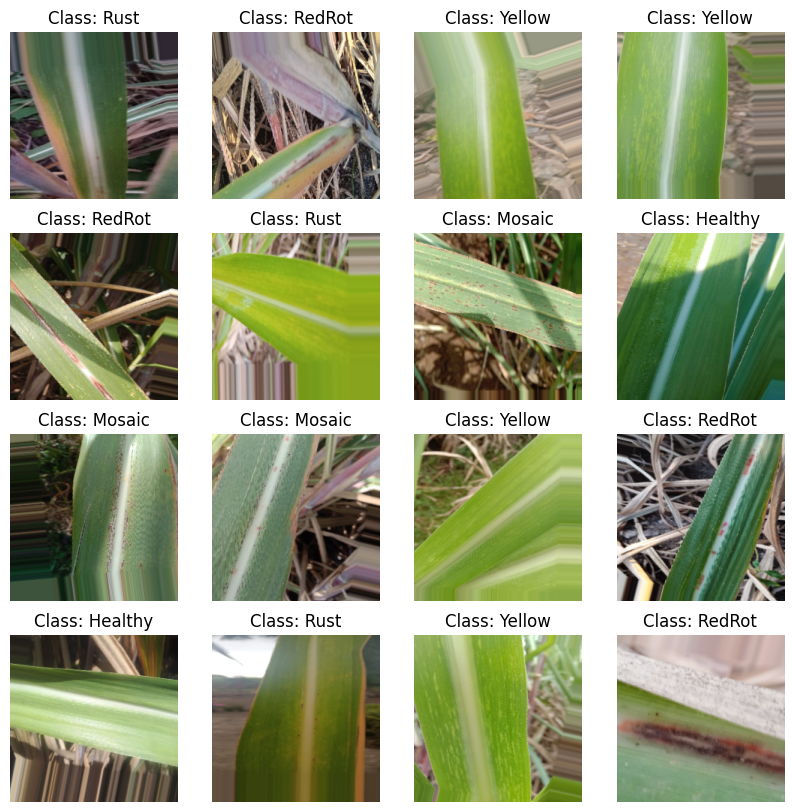

In [43]:
import matplotlib.pyplot as plt

def display_images(generator, num_rows=4, num_cols=4):
   
    images, labels = next(generator)

    
    class_indices = generator.class_indices

    
    CLASS_LABELS = ["Healthy", "Yellow", "RedRot", "Mosaic", "Rust"]

    
    class_names = [CLASS_LABELS[index] for index in range(len(CLASS_LABELS))]



    
    plt.figure(figsize=(10, 10))
    for i in range(num_rows * num_cols):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(images[i])
        plt.title(f"Class: {class_names[np.argmax(labels[i])]}")
        plt.axis('off')

    plt.show()


display_images(train_generator)


First Model Architecture


In [92]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization

model2 = Sequential()

model2.add(Conv2D(32, (3, 3), input_shape=(224, 224, 3), activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))

model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))

model2.add(Conv2D(128, (3, 3), activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))

model2.add(Flatten())

model2.add(Dense(512, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.5))

model2.add(Dense(256, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.5))

model2.add(Dense(5, activation='softmax'))

model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model2.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_567 (Conv2D)             │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_581         │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_568 (Conv2D)             │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_582         │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_569 (Conv2D)             │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_583         │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 512)            │    44,302,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_584         │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_585         │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,532,677 (169.88 MB)

 Trainable params: 44,530,693 (169.87 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [101]:

from keras.callbacks import ReduceLROnPlateau, EarlyStopping


model_checkpoint = ModelCheckpoint('inceptionv3_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-8, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

epochs = 40
history = model2.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    callbacks=[reduce_lr, early_stopping, model_checkpoint]
)




Epoch 1/40
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - accuracy: 0.5353 - loss: 1.3409
Epoch 1: val_accuracy improved from -inf to 0.18327, saving model to inceptionv3_model.keras
48/48 ━━━━━━━━━━━━━━━━━━━━ 31s 570ms/step - accuracy: 0.5357 - loss: 1.3394 - val_accuracy: 0.1833 - val_loss: 18.4986 - learning_rate: 0.0010
Epoch 2/40
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.6025 - loss: 1.1096
Epoch 2: val_accuracy did not improve from 0.18327
48/48 ━━━━━━━━━━━━━━━━━━━━ 28s 525ms/step - accuracy: 0.6028 - loss: 1.1084 - val_accuracy: 0.1833 - val_loss: 13.6835 - learning_rate: 0.0010
Epoch 3/40
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.6199 - loss: 1.0413
Epoch 3: val_accuracy did not improve from 0.18327
48/48 ━━━━━━━━━━━━━━━━━━━━ 28s 509ms/step - accuracy: 0.6201 - loss: 1.0409 - val_accuracy: 0.1833 - val_loss: 13.4558 - learning_rate: 0.0010
Epoch 4/40
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - accuracy: 0.6388 - loss: 1.0010
Epoch 4: val_accuracy did not im

In [102]:
test_loss, test_accuracy = model2.evaluate(test_generator)
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')

16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 418ms/step - accuracy: 0.8278 - loss: 0.4176
Test loss: 0.40044909715652466
Test accuracy: 0.8484252095222473


W0000 00:00:1719220088.717370     140 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [103]:
model2.save('model2_84percentacc.h5')

Using Pre Trained Models


In [52]:
from keras.applications import VGG16
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam

vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224, 3))

feature_extractor = Model(inputs=vgg16_model.input, outputs=vgg16_model.get_layer('block4_pool').output)

for layer in feature_extractor.layers:
    layer.trainable = False

x = feature_extractor.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
output = Dense(5, activation='softmax')(x)

model16 = Model(inputs=feature_extractor.input, outputs=output)


model16.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model_checkpoint = ModelCheckpoint('model.keras', monitor='val_accuracy', save_best_only=True, verbose=1, mode='max')
reduce_lr = ReduceLROnPlateau(mode='min', monitor='val_loss', factor=0.1, patience=5, min_lr=1e-8, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model16.summary()




Model: "functional_43"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_17     │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 5)              │         5,125 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,165,701 (31.15 MB)

 Trainable params: 530,437 (2.02 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [60]:
epochs = 17

history = model16.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    callbacks=[reduce_lr, early_stopping, model_checkpoint]
)

Epoch 1/17
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - accuracy: 0.6507 - loss: 0.8859

W0000 00:00:1719214614.511715     141 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy did not improve from 0.85657
48/48 ━━━━━━━━━━━━━━━━━━━━ 30s 549ms/step - accuracy: 0.6506 - loss: 0.8862 - val_accuracy: 0.7251 - val_loss: 0.7658 - learning_rate: 0.0010
Epoch 2/17


W0000 00:00:1719214618.128470     141 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - accuracy: 0.6751 - loss: 0.8348
Epoch 2: val_accuracy did not improve from 0.85657
48/48 ━━━━━━━━━━━━━━━━━━━━ 28s 518ms/step - accuracy: 0.6755 - loss: 0.8336 - val_accuracy: 0.6574 - val_loss: 0.9390 - learning_rate: 0.0010
Epoch 3/17
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - accuracy: 0.6767 - loss: 0.8283
Epoch 3: val_accuracy did not improve from 0.85657
48/48 ━━━━━━━━━━━━━━━━━━━━ 28s 515ms/step - accuracy: 0.6771 - loss: 0.8274 - val_accuracy: 0.7610 - val_loss: 0.6719 - learning_rate: 0.0010
Epoch 4/17
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - accuracy: 0.7568 - loss: 0.6717
Epoch 4: val_accuracy did not improve from 0.85657
48/48 ━━━━━━━━━━━━━━━━━━━━ 28s 515ms/step - accuracy: 0.7566 - loss: 0.6719 - val_accuracy: 0.7231 - val_loss: 0.7189 - learning_rate: 0.0010
Epoch 5/17
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.7833 - loss: 0.5983
Epoch 5: val_accuracy did not improve from 0.85657
48/48 ━━━━━━━━━━━━━━━━━━━━ 28s 513ms/

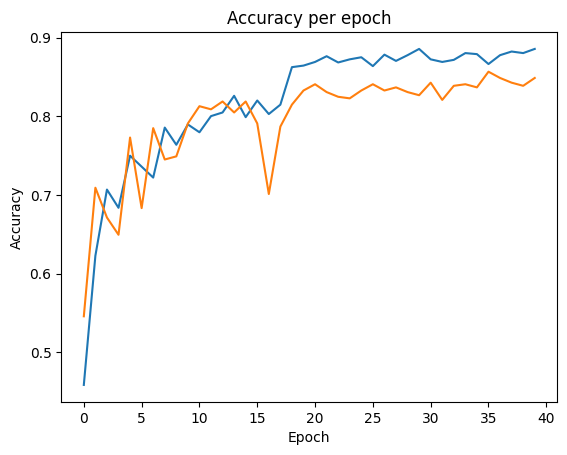

In [54]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per epoch")
plt.show()

In [63]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')

16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 221ms/step - accuracy: 0.8335 - loss: 0.4393
Test loss: 0.44055408239364624
Test accuracy: 0.8287401795387268


In [58]:
model.save('82_test_acc.h5')

MobileNetV2

In [46]:
from keras.applications import MobileNetV2
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam

mobilenet_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

feature_extractor = Model(inputs=mobilenet_model.input, outputs=mobilenet_model.output)

for layer in feature_extractor.layers:
    layer.trainable = False

x = feature_extractor.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)  
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)  
output = Dense(5, activation='softmax')(x) 

modelV2 = Model(inputs=feature_extractor.input, outputs=output)

modelV2.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model_checkpoint = ModelCheckpoint('mobilenet_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-8, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

modelV2.summary()

Model: "functional_35"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_15[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 4,097,093 (15.63 MB)

 Trainable params: 1,839,109 (7.02 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [47]:
epochs = 40

history = modelV2.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    callbacks=[reduce_lr, early_stopping, model_checkpoint]
)

Epoch 1/40
 1/48 ━━━━━━━━━━━━━━━━━━━━ 13:43 18s/step - accuracy: 0.1562 - loss: 2.0710

W0000 00:00:1719212117.938617     140 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 541ms/step - accuracy: 0.3161 - loss: 1.6175

W0000 00:00:1719212146.880511     140 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.69721, saving model to mobilenet_model.keras


W0000 00:00:1719212155.603070     142 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


48/48 ━━━━━━━━━━━━━━━━━━━━ 57s 831ms/step - accuracy: 0.3200 - loss: 1.6095 - val_accuracy: 0.6972 - val_loss: 0.9503 - learning_rate: 1.0000e-04
Epoch 2/40
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.5971 - loss: 1.0513
Epoch 2: val_accuracy did not improve from 0.69721
48/48 ━━━━━━━━━━━━━━━━━━━━ 28s 508ms/step - accuracy: 0.5971 - loss: 1.0508 - val_accuracy: 0.6853 - val_loss: 0.8290 - learning_rate: 1.0000e-04
Epoch 3/40
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - accuracy: 0.6294 - loss: 0.9272
Epoch 3: val_accuracy improved from 0.69721 to 0.73307, saving model to mobilenet_model.keras
48/48 ━━━━━━━━━━━━━━━━━━━━ 29s 521ms/step - accuracy: 0.6303 - loss: 0.9253 - val_accuracy: 0.7331 - val_loss: 0.7159 - learning_rate: 1.0000e-04
Epoch 4/40
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.6929 - loss: 0.8332
Epoch 4: val_accuracy improved from 0.73307 to 0.74701, saving model to mobilenet_model.keras
48/48 ━━━━━━━━━━━━━━━━━━━━ 28s 518ms/step - accuracy: 0.6928 - lo

In [49]:
test_loss, test_accuracy = modelV2.evaluate(test_generator)
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')

16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 222ms/step - accuracy: 0.8321 - loss: 0.4484
Test loss: 0.495183527469635
Test accuracy: 0.8129921555519104


ResNet152

In [64]:
from keras.applications import ResNet152
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam

resnet152_model = ResNet152(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = resnet152_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)  
x = Dense(1024, activation='relu')(x)
output = Dense(5, activation='softmax')(x)  
model152 = Model(inputs=resnet152_model.input, outputs=output)

for layer in resnet152_model.layers:
    layer.trainable = False

model152.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])


model_checkpoint = ModelCheckpoint('resnet152_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-8, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model152.summary()



Model: "functional_45"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_18      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_18[0… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 60,474,245 (230.69 MB)

 Trainable params: 2,103,301 (8.02 MB)

 Non-trainable params: 58,370,944 (222.67 MB)

InceptionV3

In [71]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

inceptionv3_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = inceptionv3_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(5, activation='softmax')(x) 

modelv3 = Model(inputs=inceptionv3_model.input, outputs=predictions)

for layer in inceptionv3_model.layers:
    layer.trainable = False

modelv3.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

modelv3.summary()


Model: "functional_55"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_24      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_470 (Conv2D) │ (None, 111, 111,  │        864 │ input_layer_24[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 111, 111,  │         96 │ conv2d_470[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_470      │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_471 (Conv2D) │ (None, 109, 109,  │      9,216 │ activation_470[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_471[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_471      │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_472 (Conv2D) │ (None, 109, 109,  │     18,432 │ activation_471[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_472[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_472      │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_20    │ (None, 54, 54,    │          0 │ activation_472[0… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_473 (Conv2D) │ (None, 54, 54,    │      5,120 │ max_pooling2d_20… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_473[0][0]  │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_473      │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_474 (Conv2D) │ (None, 52, 52,    │    138,240 │ activation_473[0… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_474[0][0]  │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_474      │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 23,906,085 (91.19 MB)

 Trainable params: 2,103,301 (8.02 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [72]:
# Define callbacks
model_checkpoint = ModelCheckpoint('inceptionv3_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-8, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
epochs = 40
history = modelv3.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    callbacks=[reduce_lr, early_stopping, model_checkpoint]
)


Epoch 1/40
 2/48 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - accuracy: 0.1953 - loss: 1.9122  

W0000 00:00:1719215469.675815     140 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


21/48 ━━━━━━━━━━━━━━━━━━━━ 24s 905ms/step - accuracy: 0.1894 - loss: 1.8224

W0000 00:00:1719215487.651536     140 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 609ms/step - accuracy: 0.2042 - loss: 1.7496

W0000 00:00:1719215504.867885     142 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719215519.871236     139 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.37052, saving model to inceptionv3_model.keras
48/48 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.2050 - loss: 1.7476 - val_accuracy: 0.3705 - val_loss: 1.4769 - learning_rate: 1.0000e-05
Epoch 2/40
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.3852 - loss: 1.4441
Epoch 2: val_accuracy improved from 0.37052 to 0.45618, saving model to inceptionv3_model.keras
48/48 ━━━━━━━━━━━━━━━━━━━━ 29s 529ms/step - accuracy: 0.3856 - loss: 1.4436 - val_accuracy: 0.4562 - val_loss: 1.3237 - learning_rate: 1.0000e-05
Epoch 3/40
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - accuracy: 0.5118 - loss: 1.2752
Epoch 3: val_accuracy improved from 0.45618 to 0.55976, saving model to inceptionv3_model.keras
48/48 ━━━━━━━━━━━━━━━━━━━━ 29s 537ms/step - accuracy: 0.5123 - loss: 1.2745 - val_accuracy: 0.5598 - val_loss: 1.1867 - learning_rate: 1.0000e-05
Epoch 4/40
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step - accuracy: 0.5624 - loss: 1.1746
Epoch 4: val_accuracy

In [95]:
test_loss, test_accuracy = modelv3.evaluate(test_generator)
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')

16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 236ms/step - accuracy: 0.7941 - loss: 0.5531
Test loss: 0.5449430346488953
Test accuracy: 0.8070865869522095


Ensemble Learning Second Attempt


In [96]:
modelv3.save('inceptionv3_80.h5')

In [108]:
from keras.models import load_model


model1_VGG = load_model('/kaggle/working/82_test_acc.h5')
model2_mobile = load_model('/kaggle/working/mobilenet_model.keras')
model3 = load_model('/kaggle/working/inceptionv3_80.h5')
model4 = load_model('/kaggle/working/model2_84percentacc.h5')

In [112]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


models = [model4, model1_VGG, model2_mobile, model3]
true_labels = test_generator.classes

def simple_ensemble_predict(models, data_generator):
    preds = [model.predict(data_generator) for model in models]
    preds_array = np.array(preds)
    avg_preds = np.mean(preds_array, axis=0)
    ensemble_preds = np.argmax(avg_preds, axis=1)
    return ensemble_preds

ensemble_pred_labels = simple_ensemble_predict([model1_VGG, model2_mobile, model3, model4], test_generator)
accuracy = accuracy_score(true_labels, ensemble_pred_labels)
conf_matrix = confusion_matrix(true_labels, ensemble_pred_labels)
class_report = classification_report(true_labels, ensemble_pred_labels)


16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 216ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 214ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 223ms/step
 1/16 ━━━━━━━━━━━━━━━━━━━━ 11s 734ms/step

W0000 00:00:1719220346.922421     140 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 239ms/step


W0000 00:00:1719220350.500242     140 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [119]:
print(f'Ensemble model accuracy: {accuracy:.4f}')


Ensemble model accuracy: 0.9055


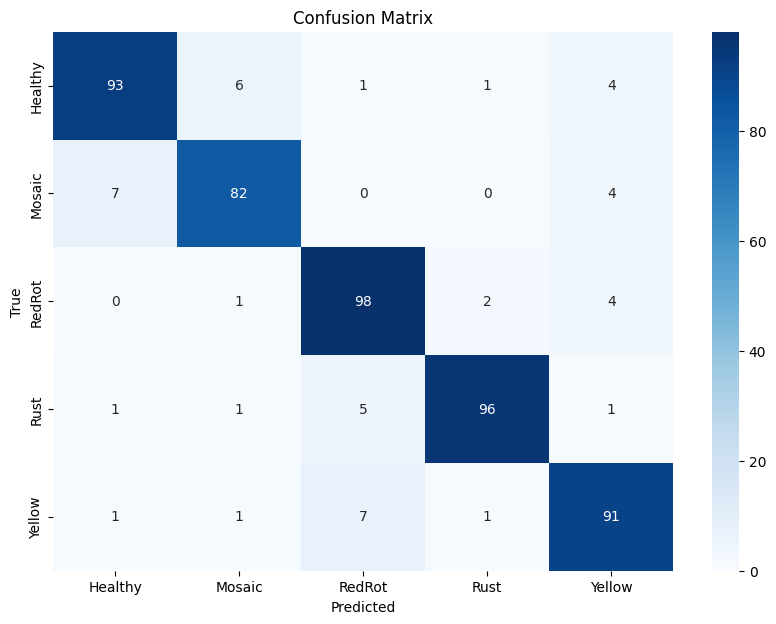

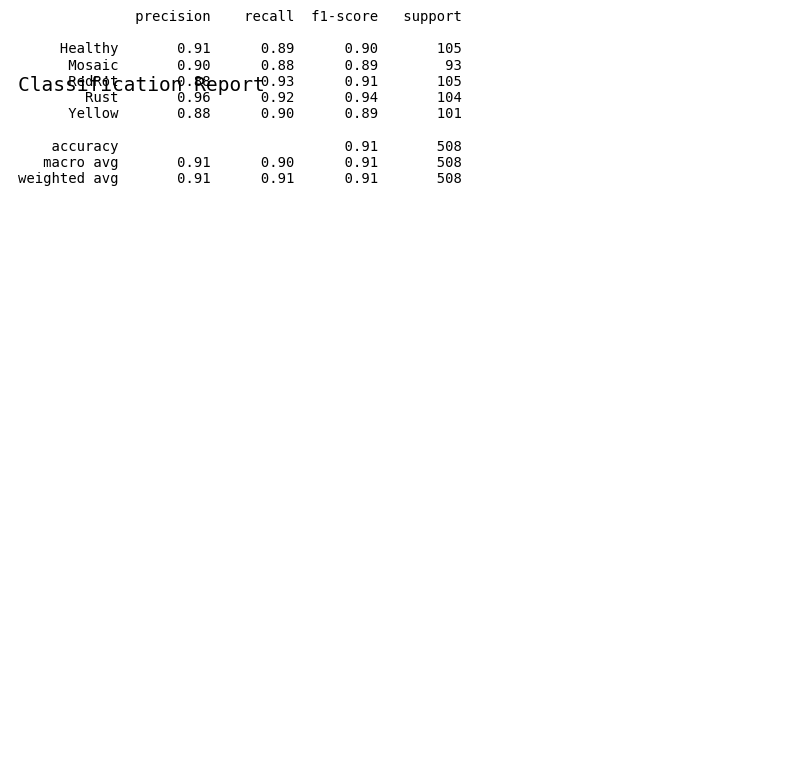

In [120]:

cm = conf_matrix

# Plot Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


classification_report_str = classification_report(true_labels, ensemble_pred_labels, target_names=test_generator.class_indices.keys())

plt.figure(figsize=(10, 7))
plt.text(0.01, 1.25, str('Classification Report'), {'fontsize': 14}, fontproperties='monospace') 
plt.text(0.01, 1.05, classification_report_str, {'fontsize': 10}, fontproperties='monospace') 
plt.axis('off')
plt.show()
